#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Interpolation and Regression

Interpolation and regression address the problem of approximating functions using their (possibly noisy) values at a finite set of points.  There is usually an underlying process from which the observed data are obtained, but this process is impractical to evaluate every time a function value is needed.  Examples of underlying processes include:

* direct field observations/measurement of a physical or social system
* numerically processed observations, perhaps by applying physical principles
* output from an expensive "exact" numerical computation
* output from an approximate numerical computation

We would like an inexpensive deterministic surrogate that we can use instead.  The most common surrogate functions are polynomials and rational functions (ratios of polynomials) because they are convenient to compute with.  Other choices are often made when there is prior knowledge about the behavior of the system, such as using

* $\sin kx$ and $\cos kx$ to represent periodic functions
* powers/exponentials ($a^x$ or $a^{1/x}$) for material properties or reaction rates (e.g., [Arhennius relations](https://en.wikipedia.org/wiki/Arrhenius_equation)).

We start our discussion by building surrogate functions that exactly match the observations at a number of points, either given or specially chosen, using polynomials.

## Polynomial Interpolation

In the Linear Algebra notebook, we discussed Vandermonde matrices which we could use to solve for polynomial coefficients.  It is also possible to compute the coefficients explicitly (rather than by solving a linear system).

### Lagrange Interpolating Polynomials

Suppose we are given function values $y_0, \dotsc, y_m$ at the distinct points $x_0, \dotsc, x_m$ and we would like to build a polynomial of degree $m$ that goes through all these points.  This explicit construction is attributed to Lagrange (though he was not first):

$$ p(x) = \sum_{i=0}^m y_i \prod_{j \ne i} \frac{x - x_j}{x_i - x_j} $$

* What is the degree of this polynomial?
* Why is $p(x_i) = y_i$?
* How expensive (in terms of $m$) is it to evaluate $p(x)$?
* How expensive (in terms of $m$) is it to convert to standard form $p(x) = \sum_{i=0}^m a_i x^i$?
* Can we easily evaluate the derivative $p'(x)$?
* What can go wrong?  Is this formulation numerically stable?

<IPython.core.display.Javascript object>


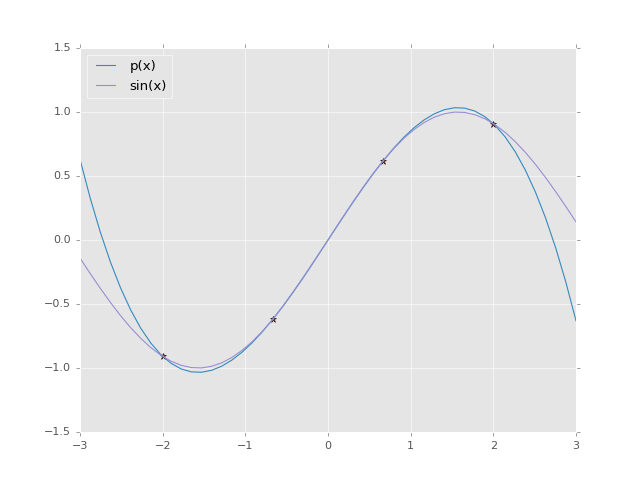

In [38]:
%matplotlib notebook
import numpy
from matplotlib import pyplot

def lagrange(x, y):
    def p(t):
        from numpy import prod
        m = len(x) - 1
        w = 0
        for i in range(m):
            w += y[i] * (prod(t - x[:i]) * prod(t - x[i+1:])
                / (prod(x[i] - x[:i]) * prod(x[i] - x[i+1:])))
        w += y[m] * prod(t - x[:m]) / prod(x[m] - x[:m])
        return w
    return numpy.vectorize(p)

x = numpy.linspace(-2,2,4)
y = numpy.sin(x)
p = lagrange(x, y)
xx = numpy.linspace(-3,3)
pyplot.style.use('ggplot')
pyplot.figure()
pyplot.plot(x, y, '*')
pyplot.plot(xx, p(xx), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')
pyplot.show()

#### Uniqueness

Is the polynomial $p(x)$ of degree $m$ that interpolates $m+1$ points unique?  Why?

### Vandermonde matrices

We have used the Vandermonde matrix with a monomial basis for polynomial interpolation.

<IPython.core.display.Javascript object>


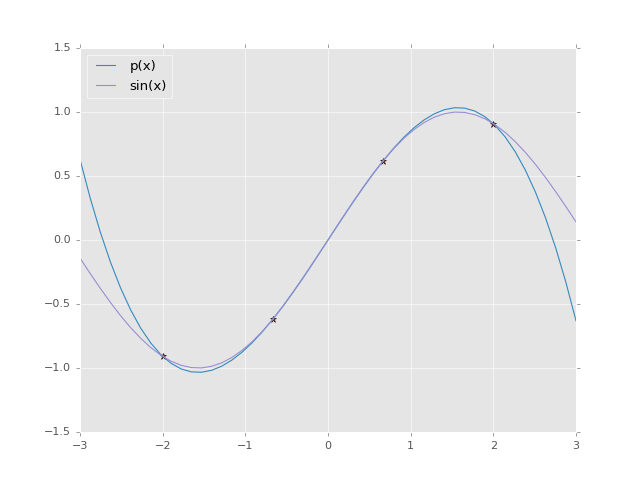

In [25]:
p = numpy.linalg.solve(numpy.vander(x), y)
pyplot.figure()
pyplot.plot(x, y, '*')
pyplot.plot(xx, numpy.vander(xx, 4).dot(p), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')

Vandermonde matrices are often ill-conditioned and this requires solving an $m\times m$ linear system, at a cost of $m^3$.

### Newton polynomials

Newton polynomials are polynomials

$$ n_k(x) = \prod_{i=0}^{k-1} (x - x_i) $$

How does the Vandermonde procedure change if we replace $x^k$ with $n_k(x)$?

In [43]:
def vander_newton(x, abscissa=None):
    if abscissa is None:
        abscissa = x
    n = len(abscissa)
    A = numpy.zeros((len(x), n))
    A[:,0] = 1
    for i in range(1,n):
        A[:,i] = A[:,i-1] * (x - abscissa[i-1])
    return A

A = vander_newton(numpy.linspace(-1,1,5))
print(A)

[[ 1.    0.   -0.    0.   -0.  ]
 [ 1.    0.5   0.   -0.    0.  ]
 [ 1.    1.    0.5   0.   -0.  ]
 [ 1.    1.5   1.5   0.75  0.  ]
 [ 1.    2.    3.    3.    1.5 ]]


* Does this affect the cost of solving for the coefficients?
* How does the condition number depend on the number and position of the points?

<IPython.core.display.Javascript object>


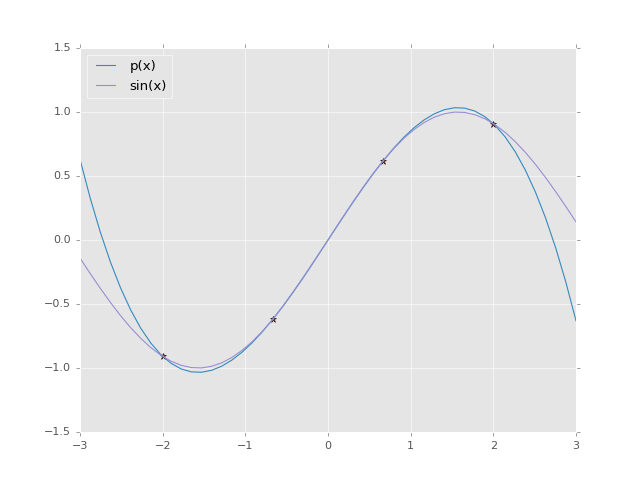

In [26]:
# First, let's check that it works.
p = numpy.linalg.solve(vander_newton(x), y)
pyplot.figure()
pyplot.plot(x, y, '*')
pyplot.plot(xx, vander_newton(xx, x).dot(p), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')

<IPython.core.display.Javascript object>


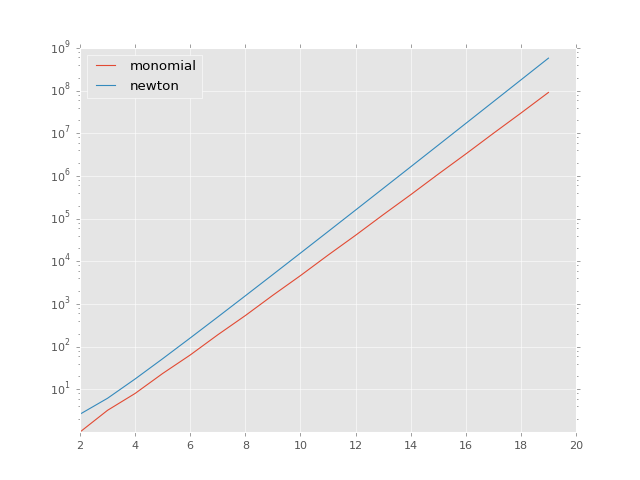

In [108]:
def cond(mat, points, interval=(-1,1), nmax=20):
    degree = numpy.arange(2, nmax)
    return degree, numpy.array([numpy.linalg.cond(mat(points(*interval,n))) for n in degree])

pyplot.figure()
pyplot.semilogy(*cond(numpy.vander, numpy.linspace), label='monomial')
pyplot.semilogy(*cond(vander_newton, numpy.linspace), label='newton')
pyplot.legend(loc='upper left')

<IPython.core.display.Javascript object>


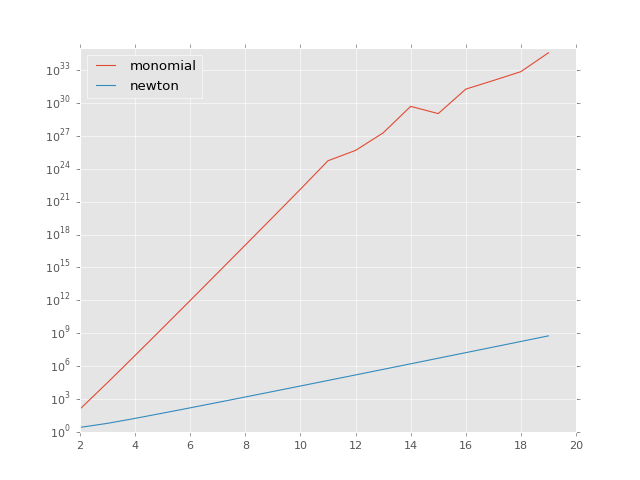

In [109]:
pyplot.figure()
pyplot.semilogy(*cond(numpy.vander, numpy.linspace, (10,12)), label='monomial')
pyplot.semilogy(*cond(vander_newton, numpy.linspace, (10,12)), label='newton')
pyplot.legend(loc='upper left')

### Conclusions

* Vandermonde matrices are typically ill-conditioned. Even with many points, columns typically become nearly linearly dependent.
* Interpolation using an arbitrary basis requires $O(n^3)$ operations for $n$ data points because we must solve with a full Vandermonde matrix.
* Newton polynomials cause the Vandermonde matrix to be triangular, thus $O(n^2)$ for interpolation.
* Newton polynomials can incrementally assimilate new observations: just add extra rows.

### Polynomial bases

We have seen that monomials and Newton bases are ill-conditioned, but we have a procedure for constructing well-conditioned bases that span the same space.

<IPython.core.display.Javascript object>


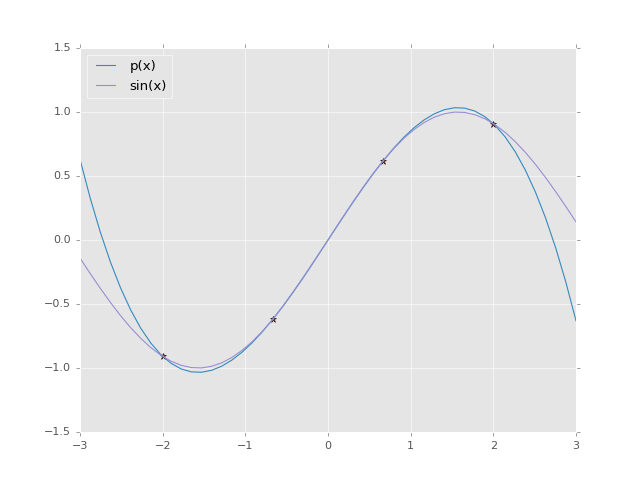

In [113]:
def vander_q(x, n=None, interval=None, print_basis=False):
    if n is None:
        n = len(x)
    if interval is None:
        a, b = min(x), max(x)
    else:
        a, b = interval
    # Set up integration on the interval [a,b] using the midpoint rule
    w = b - a
    V = numpy.vander(numpy.linspace(a + 0.5*w/100, b - 0.5*w/100, 100), n, increasing=True)
    V *= numpy.sqrt(w/100)
    Q, R = numpy.linalg.qr(V)
    if print_basis:
        print('R', R)
    A = numpy.vander(x, n, increasing=True)
    return numpy.linalg.solve(R.T, A.T).T

p = numpy.linalg.solve(vander_q(x), y)
pyplot.figure()
pyplot.plot(x, y, '*')
pyplot.plot(xx, vander_q(xx, 4, interval=(min(x), max(x))).dot(p), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')

<IPython.core.display.Javascript object>


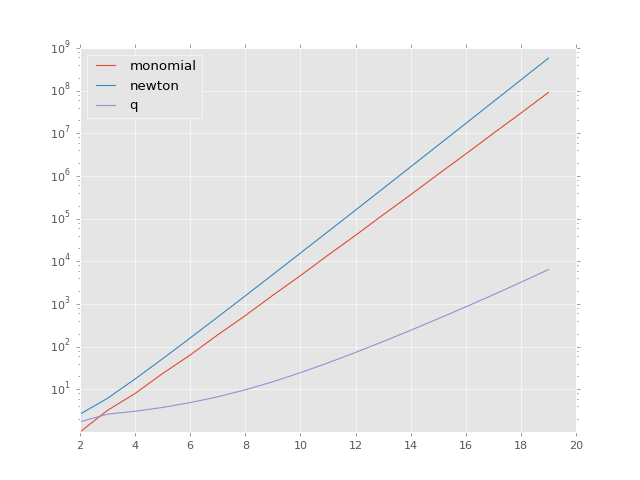

In [111]:
pyplot.figure()
pyplot.semilogy(*cond(numpy.vander, numpy.linspace, (-1,1)), label='monomial')
pyplot.semilogy(*cond(vander_newton, numpy.linspace, (-1,1)), label='newton')
pyplot.semilogy(*cond(vander_q, numpy.linspace, (-1,1)), label='q')
pyplot.legend(loc='upper left')

<IPython.core.display.Javascript object>


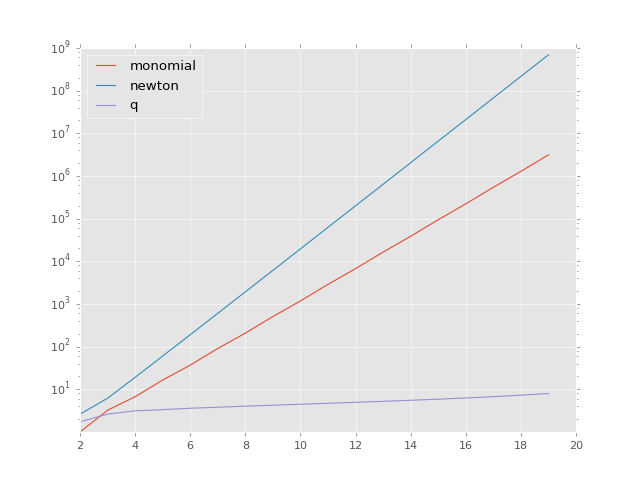

In [112]:
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(0, numpy.pi, n)))

pyplot.figure()
pyplot.semilogy(*cond(numpy.vander, cosspace, (-1,1)), label='monomial')
pyplot.semilogy(*cond(vander_newton, cosspace, (-1,1)), label='newton')
pyplot.semilogy(*cond(vander_q, cosspace, (-1,1)), label='q')
pyplot.legend(loc='upper left')

In [114]:
for n in range(2,5):
    vander_q(numpy.linspace(-1,1,n), print_basis=True)

R [[ -1.41421356e+00  -1.11022302e-16]
 [  0.00000000e+00   8.16455755e-01]]
R [[ -1.41421356e+00  -1.11022302e-16  -4.71357380e-01]
 [  0.00000000e+00   8.16455755e-01   1.38777878e-17]
 [  0.00000000e+00   0.00000000e+00  -4.21531607e-01]]
R [[ -1.41421356e+00  -1.11022302e-16  -4.71357380e-01  -5.55111512e-17]
 [  0.00000000e+00   8.16455755e-01   1.38777878e-17   4.89759149e-01]
 [  0.00000000e+00   0.00000000e+00  -4.21531607e-01  -6.59194921e-17]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.13659327e-01]]


### Observations

* Orthogonalizing the monomials makes for a much better conditioned basis.
* That basis has much smaller condition number for interpolation on equally spaced points.
* The condition number still grows exponentially.
* Using `cosspace` for interpolation with monomials or Newton basis does not qualitatively change their ill-conditioning.
* Using `cosspace` with orthogonal polynomials gives a **bounded** condition number.
* The orthogonal polynomials can be written as a linear combination of monomials.
* That is, a different sequence of constant, linear, quadratic, etc., polynomials.

### Chebyshev polynomials

Define $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, but it's not obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos (n+1) y = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos (n-1) y = \cos ny \cos y + \sin ny \sin y
\end{split}$$
    